In [1]:
from __future__ import unicode_literals
from textblob import TextBlob
import pandas as pd

In [3]:
wine = pd.read_csv('/Users/luis/Desktop/tfm_folder/winemag-data_first150k.csv.zip',sep=",")
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
wine.columns

Index([u'Unnamed: 0', u'country', u'description', u'designation', u'points',
       u'price', u'province', u'region_1', u'region_2', u'variety', u'winery'],
      dtype='object')

In [5]:
wine = wine.drop('Unnamed: 0',1)

In [6]:
wine = wine.drop_duplicates()

In [7]:
len(wine)

97851

In [8]:
# keeping only varieties with at least 20 reviews
num_reviews = wine.groupby('variety').description.count().to_frame().reset_index()
num_reviews = num_reviews[num_reviews.description > 19]
frequent_varieties = num_reviews.variety.tolist()
wine_f = wine.loc[wine['variety'].isin(frequent_varieties)]

In [9]:
len(wine_f)

95778

Ranking wine varieties by sweetness from descriptions

In [10]:
# we will do this by counting the frequency of words associated with sweetness 
# in the descriptions of each variety (the words will be "sweet","sweetness","sugar","sugary",
#"caramel", and "caramelized")

In [11]:
# first we must clean the text by removing punctuation symbols and setting all words 
# to lowercase letters
import string 

def remove_punctuation(review):
    pepe = review.translate(None, string.punctuation)
    return pepe

# removing punctuation from descriptions
wine['description'] = wine['description'].apply(remove_punctuation)
# converting to lowercase letters
wine['description'] = wine['description'].str.lower()

In [12]:
# a function to locate the maximum element of a list
import numpy as np
def locate_max(list):
    biggest = np.max(list)
    return biggest, [index for index, element in enumerate(list) 
                      if biggest == element]

In [13]:
#example, calculate the frequency of sweetness-words in descriptions of Port wine
porto = wine[wine.variety == "Port"]

sweet_freq = []
for review in porto.description:
    review = TextBlob(review.decode('unicode-escape'))
    num_sweet = review.words.count("sweet")
    num_sweetness = review.words.count("sweetness")
    num_sugar = review.words.count("sugar")
    num_sugary = review.words.count("sugary")
    num_caramel = review.words.count("caramel")
    num_caramelized = review.words.count("caramelized")
    total_sweet = num_sweet+num_sweetness+num_sugar+num_sugary+num_caramel+num_caramelized
    sweet_freq.append(total_sweet)

print(float(sum(sweet_freq))/len(sweet_freq))

/Users/luis/anaconda/lib/python2.7/site-packages/pandas/core/ops.py:739: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


0.555869872702


In [14]:
locate_max(sweet_freq)

(4, [140])

In [15]:
porto.description.iloc[140]

'this 100 petite sirah is very very sweet when the palate experiences this much concentrated brown sugar and caramel it exults the problem is that sweetness is pretty much all there is youll find blackberry jam and chocolate'

In [16]:
#writing it as a function that assigns a sweetness-score based on a list of descriptions
def sweetness_score(descriptions):
    sweet_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        num_sweet = review.words.count("sweet")
        num_sweetness = review.words.count("sweetness")
        num_sugar = review.words.count("sugar")
        num_sugary = review.words.count("sugary")
        num_caramel = review.words.count("caramel")
        num_caramelized = review.words.count("caramelized")
        total_sweet = num_sweet+num_sweetness+num_sugar+num_sugary+num_caramel+num_caramelized
        sweet_freq.append(total_sweet)
    return float(sum(sweet_freq))/len(sweet_freq)

In [17]:
sweetness_score(porto.description)

0.5558698727015559

In [18]:
#calculating the frequency of "sweetness-related" words for each variety of wine and saving 
#it in a list tuples of type (wine-variety,frequency)

sweet_list = []
for variety in wine_f.variety.unique():
    df_variety = wine_f[wine_f.variety == variety]
    sweet = sweetness_score(df_variety.description)
    sweet_list.append((variety,sweet))

# sorting from high sweeetness to low sweetness    
sorted_sweet_list = sorted(sweet_list, key=lambda x: -x[1])

In [19]:
# putting the list in dataframe format
df_sweetness = pd.DataFrame(sorted_sweet_list,columns=["variety","sweetness_score"])

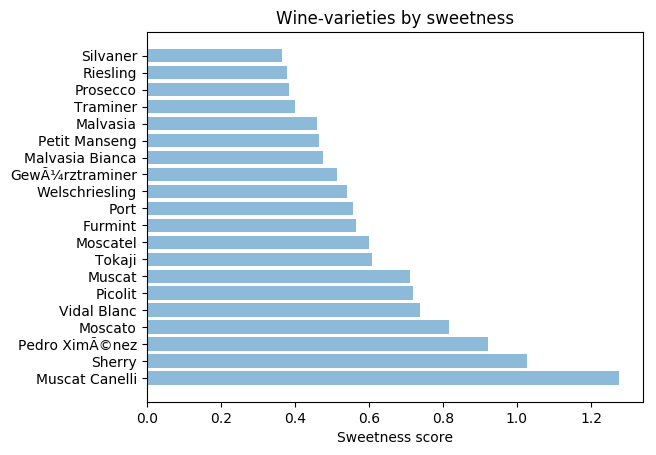

In [20]:
# Barplot of the data
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

varieties = tuple(df_sweetness.variety.tolist())[:20]
varieties = [TextBlob(i.decode('unicode-escape')) for i in varieties]
y_pos = np.arange(len(varieties))
performance = np.array(df_sweetness.sweetness_score)[:20]
error = np.random.rand(len(varieties))

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, varieties)
plt.xlabel('Sweetness score')
plt.title('Wine-varieties by sweetness')
 
plt.show()